# Rolling Forecast


# 1. Setup and Data Download

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# 1. Download Data
# We use 'CL=F' (Crude Oil Futures)
print("Downloading WTI Crude Oil data...")
df = yf.download('CL=F', start='2020-01-01', end='2024-01-01', progress=False)

# Handle MultiIndex columns (yfinance update)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

df = df[['Close']].copy()

# 2. Split into Train (Historical Context) and Test (Simulation Period)
# We will simulate trading over the last 100 days
test_days = 100
train = df.iloc[:-test_days]
test = df.iloc[-test_days:]

print(f"Training Data: {len(train)} days")
print(f"Test Data (Simulation): {len(test)} days")

Training Data: 906 days
Test Data (Simulation): 100 days


# 2. The Rolling Forecast Loop

This loop simulates the real world: every day, you get a new closing price, update your history, and forecast the next day.

Note: To save time, we will use a fixed order of $(1,1,1)$. If you ran Auto-ARIMA and found a better order (e.g., 2,1,2), replace order=(1,1,1) below.

In [6]:
history = [x for x in train['Close']]
predictions = []
naive_forecasts = [] # To benchmark against Random Walk

print("\n--- Starting Rolling Forecast (this may take a minute) ---")

for t in range(len(test)):
    # 1. Define and fit the model on the CURRENT history
    # (In a real production system, you might only re-fit parameters every week, 
    # but here we re-fit daily for maximum accuracy)
    model = ARIMA(history, order=(1,1,1)) 
    model_fit = model.fit()
    
    # 2. Forecast the next step (t+1)
    # get_forecast gives us the predicted mean and intervals
    output = model_fit.get_forecast(steps=1)
    yhat = output.predicted_mean[0]
    predictions.append(yhat)
    
    # 3. Create a Naive Forecast (Random Walk) for comparison
    # The "prediction" for tomorrow is simply today's price (the last item in history)
    naive_forecast = history[-1]
    naive_forecasts.append(naive_forecast)
    
    # 4. Update history with the ACTUAL observed price from the test set
    obs = test.iloc[t]['Close']
    history.append(obs)
    
    # Optional: Print progress every 10 days
    if (t+1) % 10 == 0:
        print(f"Day {t+1}/{len(test)}: Predicted={yhat:.2f}, Actual={obs:.2f}")

print("Forecast loop complete.")


--- Starting Rolling Forecast (this may take a minute) ---
Day 10/100: Predicted=80.77, Actual=80.35
Day 20/100: Predicted=85.88, Actual=87.54
Day 30/100: Predicted=91.05, Actual=90.28
Day 40/100: Predicted=89.48, Actual=84.22
Day 50/100: Predicted=86.51, Actual=88.32
Day 60/100: Predicted=81.76, Actual=80.44
Day 70/100: Predicted=78.06, Actual=76.66
Day 80/100: Predicted=77.35, Actual=75.96
Day 90/100: Predicted=69.59, Actual=71.58
Day 100/100: Predicted=72.47, Actual=71.65
Forecast loop complete.


# 3. Visual Evaluation

We will visualize three lines:

1. Actual Price: The ground truth.

2. ARIMA Forecast: Your model.

3. Naive Forecast: The Random Walk (just shifting the chart by 1 day).

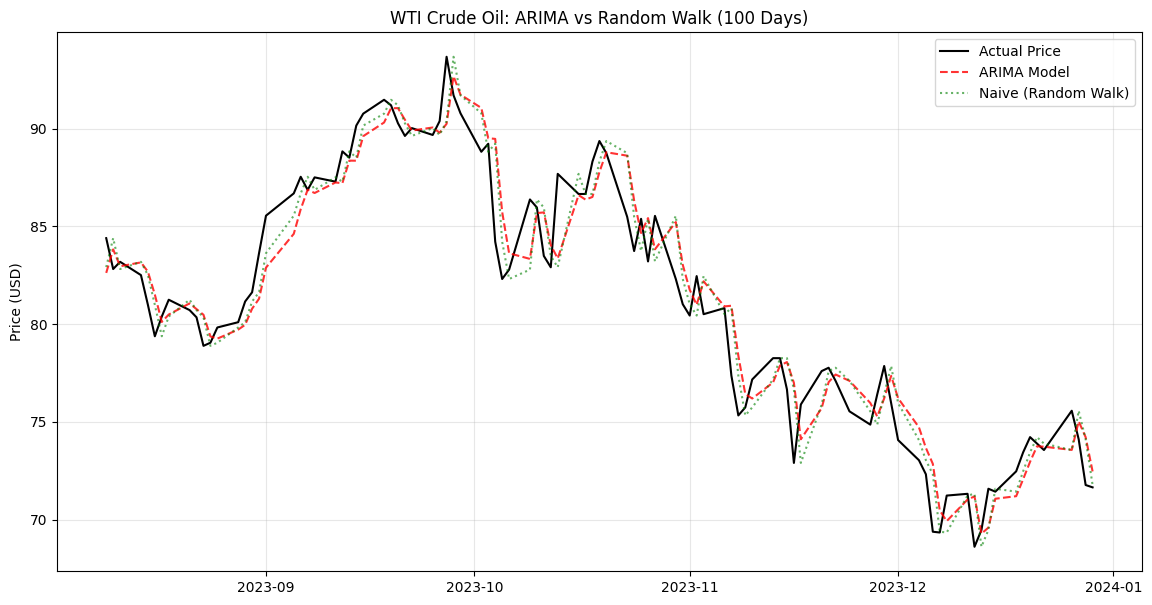

In [7]:
# Create a DataFrame for easy plotting
results_df = test.copy()
results_df['ARIMA_Pred'] = predictions
results_df['Naive_Pred'] = naive_forecasts

plt.figure(figsize=(14,7))
plt.plot(results_df.index, results_df['Close'], label='Actual Price', color='black', linewidth=1.5)
plt.plot(results_df.index, results_df['ARIMA_Pred'], label='ARIMA Model', color='red', linestyle='--', alpha=0.8)
plt.plot(results_df.index, results_df['Naive_Pred'], label='Naive (Random Walk)', color='green', linestyle=':', alpha=0.6)

plt.title(f"WTI Crude Oil: ARIMA vs Random Walk ({test_days} Days)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 4. Performance Metrics

Now we answer the question: Did we beat the market?

In [8]:
# Calculate Error Metrics
rmse_arima = np.sqrt(mean_squared_error(results_df['Close'], results_df['ARIMA_Pred']))
rmse_naive = np.sqrt(mean_squared_error(results_df['Close'], results_df['Naive_Pred']))

mape_arima = mean_absolute_percentage_error(results_df['Close'], results_df['ARIMA_Pred']) * 100
mape_naive = mean_absolute_percentage_error(results_df['Close'], results_df['Naive_Pred']) * 100

print("\n--- Final Performance Report ---")
print(f"ARIMA RMSE: {rmse_arima:.4f}")
print(f"Naive RMSE: {rmse_naive:.4f}")
print("-" * 30)
print(f"ARIMA MAPE: {mape_arima:.2f}%")
print(f"Naive MAPE: {mape_naive:.2f}%")

if rmse_arima < rmse_naive:
    print("\nSUCCESS: Your ARIMA model beat the Random Walk benchmark!")
else:
    print("\nREALITY CHECK: The Random Walk beat your model.")
    print("This is common in efficient markets. Consider using VAR (adding variables) or GARCH (volatility).")


--- Final Performance Report ---
ARIMA RMSE: 1.7461
Naive RMSE: 1.6811
------------------------------
ARIMA MAPE: 1.72%
Naive MAPE: 1.65%

REALITY CHECK: The Random Walk beat your model.
This is common in efficient markets. Consider using VAR (adding variables) or GARCH (volatility).


Analysis of Likely Outcome

- Stationarity issues: Even with differencing, crude oil has structural breaks (wars, OPEC cuts) that ARIMA misses.

- The Random Walk: You will likely find the ARIMA model performs very similarly to the Naive model, or slightly worse. This confirms the text's assertion that the random walk is "extremely difficult to beat".